<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/kl_divergence_oil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings;warnings.simplefilter('ignore')
from tqdm import tqdm_notebook as tqdm
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def mape_vectorized_v2(a, b):
    a = np.array(a)
    b = np.array(b) 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()
def metric(y_t,y_p,name):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':np.sqrt(mean_squared_error(y_t,y_p)),
         'MAPE':mape_vectorized_v2(y_t,y_p)
         }
  return pd.DataFrame(res,index=[name])

In [3]:
import numpy as np

def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))
print(KL([1,1,1],[1,1,1]))
print(KL([1,1,1.1],[1,1,1]))

0.0
0.10484119778475744


In [4]:
train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/輕油實驗數據_保留絕大部份欄位.csv')

for col in tqdm(train.columns):
  train[col] = pd.to_numeric(train[col],errors='coerce')

features = ['T10','T50','T90','N+A']
y_columns = train.columns.tolist()[10:-1]

train = train[features+y_columns]
train = train.replace([np.inf,-np.inf],np.nan)
train = train.dropna()

print(train.shape)
train.head()


(4803, 27)


,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


In [5]:
test = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0)

for col in tqdm(test.columns):
  test[col] = pd.to_numeric(test[col],errors='coerce')

test = test[features+y_columns]
test = test.replace([np.inf,-np.inf],np.nan)
test = test.dropna()
print(test.shape)
test.head()


(250, 27)


,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
2,70.1,101.6,132.2,39.082932,6.819271,5.891867,0.771648,5.836773,7.357714,6.355753,0.659941,5.309983,6.537441,11.889440,2.175804,5.337691,8.360263,9.078996,3.419692,2.224309,6.563137,4.008402,0.522953,0.057245,0.621373,0.165602,0.034701
3,74.9,105.9,138.6,39.082932,6.819271,5.891867,0.771648,5.836773,7.357714,6.355753,0.659941,5.309983,6.537441,11.889440,2.175804,5.337691,8.360263,9.078996,3.419692,2.224309,6.563137,4.008402,0.522953,0.057245,0.621373,0.165602,0.034701
4,60.4,97.9,144.4,40.934064,12.061397,8.788561,1.018949,6.671666,8.024599,10.116494,3.755812,4.855465,4.197693,12.283775,4.139793,3.781476,4.404284,3.863638,3.345833,2.205359,2.984103,1.368210,0.800960,0.414533,0.676800,0.070908,0.169692
5,100.4,114.0,137.0,53.849498,0.152985,0.054995,0.125987,2.097767,1.214444,7.428715,2.663734,6.475165,5.259181,15.397940,6.812319,7.602400,9.434827,8.037266,7.481252,3.877234,8.225184,3.917980,1.569843,0.421814,1.334506,0.127167,0.287296
6,105.7,127.5,154.6,44.225827,0.334270,0.215481,0.153186,2.306365,2.733433,3.013477,0.453959,4.235994,4.640280,8.692144,3.097721,6.825638,9.400184,8.999908,6.979372,5.567792,11.825300,7.673652,3.166715,1.524705,6.164731,0.415157,1.580535


In [0]:
y_name = 'C8A'

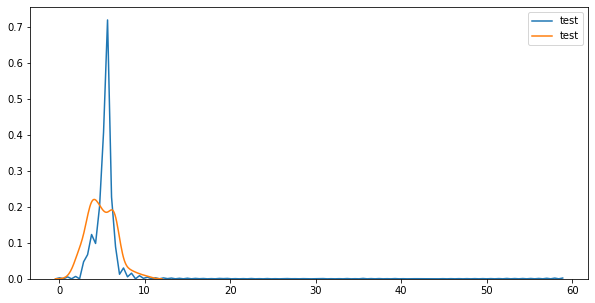

In [7]:
plt.figure(figsize=(10,5))
sns.kdeplot(train[y_name],label='test')
sns.kdeplot(test[y_name],label='test')

In [8]:
best_KL_value = 10000
iter_num = 10000
for _ in range(iter_num):
  sample_train = train[y_name].sample(len(test))
  KL_value = abs(KL(sample_train,test[y_name]))
  if abs(KL_value) < best_KL_value:
    best_KL_value = KL_value
    best_sample_train = sample_train 
    print(best_KL_value)
print(best_KL_value)

262.62297440896054
201.84146565451084
165.49385727022886
153.43645609171912
151.6912914553738
145.17969493250206
144.37085118652058
144.37085118652058


In [9]:
abs(KL(best_sample_train,test[y_name]))

144.37085118652058

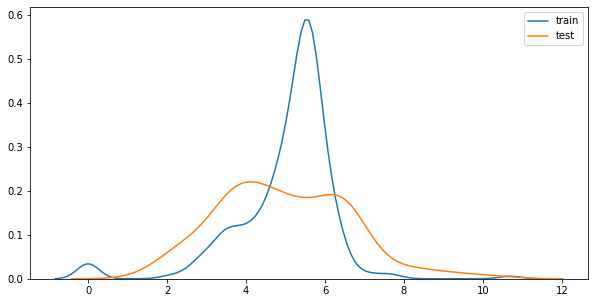

In [10]:
plt.figure(figsize=(10,5))
sns.kdeplot(best_sample_train,label='train')
sns.kdeplot(test[y_name],label='test')

In [11]:
train_sample = train.loc[best_sample_train.index,:]
print(train_sample.shape)

(250, 27)


In [12]:
test_200 = test[test.index%5 != 0]
test_50 = test[test.index%5 == 0]
train_sample = train_sample.append(test_200)
train_sample.shape

(450, 27)

In [13]:
test_50 = test_50.drop(95)
test_50.shape

(49, 27)

In [14]:
model = XGBRegressor()
model.fit(train_sample[features],train_sample[y_name])
y_pred = model.predict(test_50[features])

[07:07:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [15]:
metric(test_50[y_name],y_pred,y_name)

,R2,RMSE,MAPE
C8A,0.784897,0.66477,0.109361
